In [1]:
import os 
os.environ["OPENBLAS_NUM_THREADS"] = "10"

import json 
import cv2
import re
import random
import time
from tqdm.notebook import tqdm
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from pattern.text.en import singularize, pluralize

import torch
import clip
from PIL import Image

import nengo.spa as spa
from utils import *
from dataset import GQADataset

RANDOM_SEED = 17

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DATA_PATH = '/scratch/penzkofer/GQA'
    
print(clip.available_models())

CUDA_DEVICE = 7
torch.cuda.set_device(CUDA_DEVICE)

device = torch.device("cuda:" + str(CUDA_DEVICE))
clip_model, preprocess = clip.load("ViT-B/32", device=device)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [2]:
%%time

# define SSP vector space 
res = 100
dim = 1024
new_size = (25, 25)  # size should be smaller than resolution

xs = np.linspace(0, new_size[1], res)
ys = np.linspace(0, new_size[0], res)
ws = np.linspace(1, 10, 10)
hs = np.linspace(1, 10, 10)

rng = np.random.RandomState(seed=RANDOM_SEED)
x_axis = make_good_unitary(dim, rng=rng)
y_axis = make_good_unitary(dim, rng=rng)
w_axis = make_good_unitary(dim, rng=rng)
h_axis = make_good_unitary(dim, rng=rng)

print(f'Size of vector space: {res**2}x{10**2}x{dim}')
print(f'x-axis resolution = {len(xs)}, y-axis resolution = {len(ys)}')
print(f'width resolution = {len(ws)}, height resolution = {len(hs)}')

# precompute all vectors -- this will take some time 
VECTORS = get_heatmap_vectors_multidim(xs, ys, ws, hs, x_axis, y_axis, w_axis, h_axis)
print(VECTORS.shape)

Size of vector space: 10000x100x512
x-axis resolution = 100, y-axis resolution = 100
width resolution = 10, height resolution = 10
(100, 100, 10, 10, 512)
CPU times: user 7min 11s, sys: 2.2 s, total: 7min 13s
Wall time: 7min 13s


### Image to SSP memory 

In [24]:
TEST = False

# load questions, programs and scenegraphs
if TEST: 
    questions_path = 'val_balanced_questions.json'
    programs_path = 'programs/trainval_balanced_programs.json'
    scene_path = 'val_sceneGraphs.json'
else: 
    questions_path = 'train_balanced_questions.json'
    programs_path = 'programs/trainval_balanced_programs.json'
    scene_path = 'train_sceneGraphs.json'

with open(os.path.join(DATA_PATH, questions_path), 'r') as f:
    questions = json.load(f)

with open(os.path.join(DATA_PATH, programs_path), 'r') as f:
    programs = json.load(f)

with open(os.path.join(DATA_PATH, scene_path), 'r') as f:
    scenegraphs = json.load(f)


columns = ['semantic', 'entailed', 'equivalent', 'question', 'imageId', 'isBalanced', 'groups', 
                   'answer', 'semanticStr', 'annotations', 'types', 'fullAnswer']

questions = pd.DataFrame.from_dict(questions, orient='index', columns=columns)
questions = questions.reset_index()
questions = questions.rename(columns={"index": "questionID"}, errors="raise")
            
columns = ['imageID', 'question', 'program', 'questionID', 'answer']
programs = pd.DataFrame(programs, columns=columns)

DATA = GQADataset(questions, programs, scenegraphs, vectors=VECTORS, path=os.path.join(DATA_PATH, 'images/images/'),
                  axes=[x_axis, y_axis, w_axis, h_axis], linspace=[xs, ys, ws, hs], visualize=True)

print(f'Length of {"test" if TEST else "train"} data set: ', len(DATA))

for i in range(5):
    print(i, questions.iloc[i].questionID, questions.iloc[i].question, questions.iloc[i].imageId)

943000
0 02930152 Is the sky dark? 2354786
1 07333408 What is on the white wall? 2375429
2 07333405 Is that pipe red? 2375429
3 15736264 Is the tall clock small or large? 2368326
4 111007521 Who is wearing a shirt? 2331819


In [14]:
from run_programs import *

def run_program(data, img, info, counter, memory, dim, verbose=0):
    """ run program for question on given image: 
    for each step in program select appropriate function
    """
    scale, w_scale, h_scale = info['scales']
    img_size = img.shape[:2]

    results = []
    last_step = False
    last_func = None
    
    for i, step in enumerate(info['program']): 
        
        if i+1 == len(info['program']): 
            last_step = True
    
        _, func = step.split('=')
        attr = func.split('(')[-1].split(')')[0].split(',')
        
        if verbose > 0: 
            print(f'{i+1}. step: \t {func}')
        
        if 'select' in func: 
            obj = attr[0].strip()
            res = select_func(data, img, obj, info, counter, memory, visualize=VISUALIZE)
            
            results.append(res)
            
            if res is None:
                if verbose > 1: 
                    print(f'Could not find {obj}')
                
        
        elif 'relate' in func: 
        
            found_rel_obj = relate_func(data, func, attr, results, info, dim, memory, visualize=VISUALIZE)

            if found_rel_obj is not None:
                assert found_rel_obj in info['encoded_ssps'], f'Result of {func}: {found_rel_obj} is not encoded'
                
                selected_ssp = info['encoded_ssps'][found_rel_obj]     
                _, selected_pos = select_ssp(found_rel_obj, memory, info['encoded_ssps'], data.ssp_vectors, data.linspace)
                results.append([found_rel_obj, selected_ssp, selected_pos])

                if last_step:
                    return 'yes' 
            else:
                results.append(None)
                
                if last_step:
                    return 'no'  
                
        elif 'filter' in func: 
            
            last_filter = filter_func(func, img, attr, img_size, results, info, visualize=VISUALIZE)

            if last_filter: 
                results.append(results[-1])
            else:
                if results[-1] is None: 
                    results.append(None)
                elif results[-1][0].split("_")[0] + "_" + str(counter+1) in info['encoded_ssps'].keys():
                    counter += 1
                    return None
                else: 
                    last_filter = False
                    results.append(results[-1])
                    
                
        elif 'verify' in func: 
            pred = verify_func(data, img, attr, results, info, dim, memory, verbose=verbose, visualize=VISUALIZE)
            
            if 'verify_relation_name' in func or 'verify_relation_inv_name' in func: 
                results.append(results[-1] if pred else None)
            else:
                results.append(pred)

            if last_step:
                return 'yes' if pred else 'no'
                
            
        elif 'query' in func: 

            return query_func(func, img, attr, results, info, img_size, dim, verbose=verbose, visualize=VISUALIZE)
        
        elif 'exist' in func: 

            num = int(re.findall(r'\d+', attr[0])[0])

            if last_step:
                return 'yes' if results[num] is not None else 'no'
            else:
                if results[num] is not None and 'filter' not in last_func: 
                    results.append(True)
                elif results[num] is not None and last_filter:
                    results.append(True)
                else:
                    results.append(False)

        elif 'or(' in func: 
            attr1 = int(re.findall(r'\d+', attr[0])[0])
            attr2 = int(re.findall(r'\d+', attr[1])[0])
            return 'yes' if results[attr1] or results[attr2] else 'no'

        elif 'and(' in func: 
            attr1 = int(re.findall(r'\d+', attr[0])[0])
            attr2 = int(re.findall(r'\d+', attr[1])[0])
            return 'yes' if results[attr1] and results[attr2] else 'no'
        
        elif 'different' in func: 
            
            if len(attr) == 1:
                print('[WARNING]'+f'{func} cannot be computed')
                return None 
            
            else:    
                pred_attr1 = query_func(f'query_{attr[2].strip()}', img, [attr[0], attr[2]], results, info, img_size, dim)
                pred_attr2 = query_func(f'query_{attr[2].strip()}', img, [attr[1], attr[2]], results, info, img_size, dim)

                if pred_attr1 != pred_attr2:
                    return 'yes'
                else:
                    return 'no'
            
        elif 'same' in func: 
            
            if len(attr) == 1:
                print('[WARNING]'+f'{func} cannot be computed')
                return None 
            
            pred_attr1 = query_func(f'query_{attr[2].strip()}', img, [attr[0], attr[2]], results, info, img_size, dim)
            pred_attr2 = query_func(f'query_{attr[2].strip()}', img, [attr[1], attr[2]], results, info, img_size, dim)
            
            if pred_attr1 == pred_attr2:
                return 'yes'
            else:
                return 'no'
        
        elif 'choose' in func: 
            return choose_func(data, img, func, attr, img_size, results, info, dim, memory, visualize=VISUALIZE)
            
        else: 
            print('[WARNING]'+f'{func} not implemented')
            return -1
        
        last_func = func
        
        

425457
Question #16402843: 
Are there any knives or glasses that are black?
[yes] Yes, the knife is black.

Program:
0. select(knife)
1. filter([0], black)
2. exist([1])
3. select(glass)
4. filter([3], black)
5. exist([4])
6. or([2],[5])

Average mean-squared error of 2D locations: 41.5312
Average IoU of 4D bounding boxes: 0.67
Correct items: 12 / 17



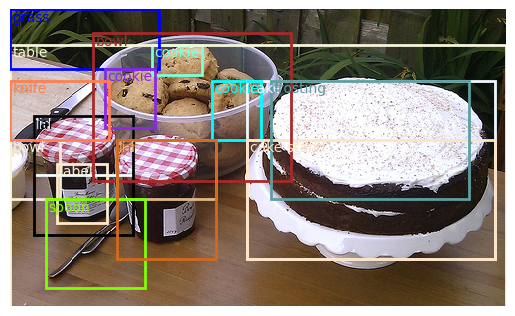

1. step: 	 select(knife)


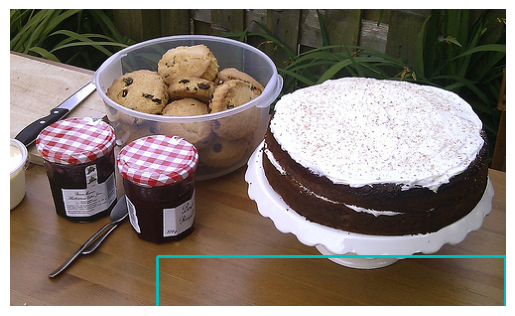

2. step: 	 filter([0], black)


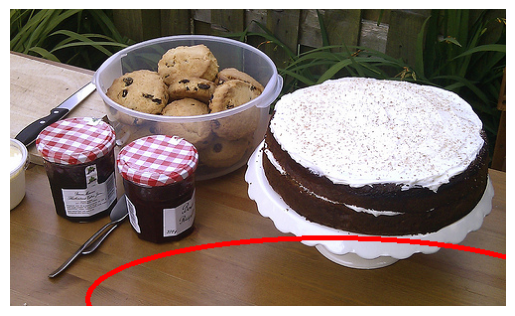

CLIP
[0.5888671875, 0.4111328125]
The knife is  black
3. step: 	 exist([1])
4. step: 	 select(glass)
Could not find glass
5. step: 	 filter([3], black)
6. step: 	 exist([4])
7. step: 	 or([2],[5])

Question: Are there any knives or glasses that are black?
Answer: yes
Answer "yes" is correct

🎊 🎊 🎊 

Took 1.90 seconds


In [26]:
IDX = np.random.randint(len(DATA))
VISUALIZE = True

start = time.time()

print(IDX)
DATA.print_item(IDX)
DATA.set_visualize(False)
DATA.set_verbose(1)
img, info, memory = DATA.encode_item(IDX, dim=dim)
avg_mse, avg_iou, correct_items = DATA.decode_item(img, info, memory)
print()

img_size = np.array(img.shape[:2])
fig, ax = plt.subplots(1,1)

ax.imshow(img, interpolation='none', origin='upper', vmin=0, vmax=1,
          extent=[0, img_size[1] / info['scales'][0], img_size[0] / info['scales'][0], 0], cmap='gray')

for i, obj in enumerate(info['encoded_items'].items()):
    name, [x, y, width, height] = obj
    name = name.split('_')[0]
        
    width, height = (width * info['scales'][1]) / info['scales'][0], (height * info['scales'][2]) / info['scales'][0] 
    rect = patches.Rectangle((x, y),
                             width, height,
                             linewidth = 2,
                             label = name,
                             edgecolor = RGB_COLORS[i],
                             facecolor = 'none')
    ax.add_patch(rect)
    plt.text(x+0.2, y+1, name, fontsize='medium', color=RGB_COLORS[i])

plt.axis('off')
plt.show()

answer = run_program(DATA, img, info, counter=1, memory=memory, dim=dim, verbose=2)

time_in_sec = time.time() - start
correct = answer == info["answer"]

print()
print(f'Question: {info["question"]}')
print(f'Answer: {answer}')
print(f'Answer "{answer}" is {"correct" if correct else "incorrect"}\n')
if correct:
    print('\U0001F38A \U0001F38A \U0001F38A \n')
    
print(f'Took {time_in_sec:.2f} seconds')